# Simulation of the 7 Qubit Steane QEC Code

ECE 621 Quantum Error Correction Final Project

Author: Grant Eberle

Imports and Setup

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, Aer, transpile, execute
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.providers.aer.noise import depolarizing_error, phase_damping_error
from qiskit.providers.aer import AerSimulator
from matplotlib import pyplot as plt
import numpy as np

# Set simulator backend 
sim = Aer.get_backend('statevector_simulator')

## ------- Code Used for Simulations -------

Function for Creating Logical |0> 

In [2]:
"""
Encodes the logical |0> state 
    circuit: circuit output
    logRegister: QuantumRegister of logical qubits in the circuit
"""
def prepLogicalZero(circuit, logRegister):
    circuit.h(logRegister[0])
    circuit.h(logRegister[1])
    circuit.h(logRegister[3])
    circuit.cx(logRegister[0], logRegister[2])
    circuit.cx(logRegister[3], logRegister[5])
    circuit.cx(logRegister[1], logRegister[6])
    circuit.cx(logRegister[0], logRegister[4])
    circuit.cx(logRegister[3], logRegister[6])
    circuit.cx(logRegister[1], logRegister[5])
    circuit.cx(logRegister[0], logRegister[6])
    circuit.cx(logRegister[1], logRegister[2])
    circuit.cx(logRegister[3], logRegister[4])
    return   

Functions for Stabilizer Encoding 

In [3]:
# Stabilizer Mappings
# (Same for X and Z checks because CSS code)
S0 = np.array([3, 4, 5, 6])
S1 = np.array([1, 2, 5, 6])
S2 = np.array([0, 2, 4, 6])

"""
Encodes a specified stabilizer in a given circuit
    circuit: circuit output
    logRegister: QuantumRegister of logical qubits in the circuit
    logQubits: qubit indexes of for stabilizer 
    synRegister: QuantumRegister of syndrome qubits in the circuit
    synQubit: index that identifies the syndrome qubit to encode 
    flag: True -> encode Z stabilizer, False -> encode X stabilizer 
"""
def encodeStabs(circuit, logRegister, logQubits, synRegister, synQubit, flag):
        for i in logQubits:
            if flag:
                circuit.cz(logRegister[i], synRegister[synQubit])
            else:
                circuit.cx(synRegister[synQubit], logRegister[i])
        return
       
def encodeXStabs(circuit, logRegister, logQubits, synRegister, synQubit):
    encodeStabs(circuit, logRegister, logQubits, synRegister, synQubit, False)
    return
        
def encodeZStabs(circuit, logRegister, logQubits, synRegister, synQubit):
    encodeStabs(circuit, logRegister, logQubits, synRegister, synQubit, True)
    return

Functions for Syndrome Extraction and Decoding 

In [4]:
"""
Decodes a syndrome measurement for correction 
    circuit: circuit output
    logRegister: QuantumRegister of logical qubits in the circuit
    synMeasurment: Measured value of the synRegister
    swap: True -> decode Z stabilizer, False -> decode X stabilizer  
        (Note: assumes synRegister is prepared in the proper state for decoding/correction)
"""
def decodeSyns(circuit, logRegister, synMeasurement, flag):
    if flag: # Z Syndrome -> X correction
        for i in range(1, logRegister.size + 1):
            circuit.x(logRegister[i - 1]).c_if(synMeasurement, i)
    else: # X Syndrome -> Z correction
        for i in range(1, logRegister.size + 1):
            circuit.z(logRegister[i - 1]).c_if(synMeasurement, i)
    return
    
def decodeXSyndromes(circuit, logRegister, synMeasurement):
    decodeSyns(circuit, logRegister, synMeasurement, False)
    return
    
def decodeZSyndromes(circuit, logRegister, synMeasurement):
    decodeSyns(circuit, logRegister, synMeasurement, True)
    return

Function for Single Gate Errors 

In [5]:
"""
Adds "level" number of gates to random qubits on the register with a probabilty based on prob
    gate: the gate to be applied as a flip error
    register: the register where the error gate will be applied
    level: level of error that indicates the number of gates applied
    prob: the physical error probability of each gate application
"""
def flipError(gate, register, level, prob):
    if level == 0: 
        return
    for i in range(level):
        randProb = np.random.uniform(0, 1)
        qubit = np.random.randint(0, register.size)
        if randProb <= prob:
            gate(register[qubit])
    return

Function For Conducting a Single Round of Error Correction 

In [6]:
"""
Preforms one round of error correction on a given circuit
    circuit: the full QuantumCircuit
    logRegister: QuantumRegister of logRegisterical qubits in the circuit
    xSynRegister: QuantumRegister of x syndrome qubits in the circuit
    zSynRegister: QuantumRegister of z syndrome qubits in the circuit
    xMeasurments: ClassicalRegiser of x syndrome measurements in the circuit
    zMeasurments: ClassicalRegiser of z syndrome measurements in the circuit
    ---
    errorLevel: is an optional error level for including measurement errors (for phenom model)
    pError: is an optional error rate for including measurement errors (for phenom model)
"""
def errorCorrection(circuit, logRegister, xSynRegister, zSynRegister, xMeasurments, zMeasurments, errorLevel, pError):
    
    """ Encoding """ 
    # X Stabilizers
    encodeXStabs(circuit, logRegister, S0, xSynRegister, 0)
    encodeXStabs(circuit, logRegister, S1, xSynRegister, 1)
    encodeXStabs(circuit, logRegister, S2, xSynRegister, 2)

    # Z Stabilizers
    encodeZStabs(circuit, logRegister, S0, zSynRegister, 0)
    encodeZStabs(circuit, logRegister, S1, zSynRegister, 1)
    encodeZStabs(circuit, logRegister, S2, zSynRegister, 2)
    
    """ Add Measurement Errors """
    flipError(circuit.z, xSynRegister, errorLevel, pError)
    flipError(circuit.z, zSynRegister, errorLevel, pError)

    """ Syndrome Extraction """
    # Measure in X basis
    circuit.h(xSynRegister) 
    circuit.h(zSynRegister)
    circuit.measure(xSynRegister, xMeasurments)
    circuit.measure(zSynRegister, zMeasurments)
    
    """ Syndrome Decoding and Correction """
    # Decode and Correct X
    decodeXSyndromes(circuit, logRegister, xMeasurments)

    # Decode and Correct Z
    decodeZSyndromes(circuit, logRegister, zMeasurments)
    
    return

Function For Verifying the Logical State 

In [7]:
"""
Checks a given statevector against a correct logical state
    statevector: given statevector of a measured state
    correctLogState: Array of string values for each correct superposition state
    printText: Shows visual of result if true
    returns: True if equal, false if not
"""
def verifyLogicalState(statevector, correctLogState, printText):
    
    # Collect Measured States
    indices = []       
    for i in range(statevector.dim):
        if statevector[i] != 0:
            indices.append( ((str(bin(i)[2:]).zfill(3+7)), statevector[i]) )

    # Check for size difference
    if not (len(indices) == len(correctLogState)):
        return False
    
    # Print Results
    if printText:
        print('Correct: | Measured:')
    j = 0
    for i in indices:
        correct = correctLogState[j]
        measured = str(i[0][3:10][::-1])
        if printText:
            print(correct, ' | ', measured, ' === ', correct == measured)
        if not correct == measured:
            return False
            
        j = j + 1
        
    return True

Ideal Circuit Simulation

In [8]:
"""
Runs a basline simulation for testing logical |0> state prep
    sim: the simulator used for the simulation
    returns: statvector of the system after simulation (single shot statvector sim)
"""
def zeroLogCircuitSim(sim):
    ## Circuit Prep
    # Logical Qubit Register
    log = QuantumRegister(7, name = "logical")

    # Circuit
    circuit = QuantumCircuit(log) 
    
    # X Syndromes
    xSyn = AncillaRegister(3, name = "xSyn")

    # Z Syndromes
    zSyn = AncillaRegister(3, name = "zSyn")

    # X Syndrome Measurements
    xMeas = ClassicalRegister(3, name = "xMeas")

    # Z Syndrome Measurements
    zMeas = ClassicalRegister(3, name = "zMeas")

    # Full Circuit
    circuit = QuantumCircuit(log, xSyn, zSyn, xMeas, zMeas)

    # Prepare Logical |0> state
    prepLogicalZero(circuit, log)
    
    return execute(circuit, sim, shots = 1).result().get_statevector()

In [9]:
"""
Runs a simulation with multiple error options
    errorLevel: max number of single qubit gate errors introduced
    pError: error rate of single qubit error gates
    sim: the simulator used for the simulation
    measError: True -> adds errors in sydrome extraction measurements, False does not
        (for code capacity vs phenom level sims)
    returns: statvector of the system after simulation (single shot statvector sim)
"""
def errorCircuitSim(errorLevel, pError, sim, measError):
    ## Circuit Prep
    # Logical Qubit Register
    log = QuantumRegister(7, name = "logical")

    # X Syndromes
    xSyn = AncillaRegister(3, name = "xSyn")

    # Z Syndromes
    zSyn = AncillaRegister(3, name = "zSyn")

    # X Syndrome Measurements
    xMeas = ClassicalRegister(3, name = "xMeas")

    # Z Syndrome Measurements
    zMeas = ClassicalRegister(3, name = "zMeas")

    # Full Circuit
    circuit = QuantumCircuit(log, xSyn, zSyn, xMeas, zMeas)

    ## State Prep
    # Set Syndrome Qubits to |+>
    for i in range(xSyn.size):   
        circuit.h(xSyn[i])
        circuit.h(zSyn[i])   

    # Prepare Logical |0> state
    prepLogicalZero(circuit, log)
    
    """ APPLY ERRORS """  
    # Bit Flip Error
    flipError(circuit.x, log, errorLevel, pError)
    # Phase Flip Error
    flipError(circuit.z, log, errorLevel, pError)
    
    # Error Correction
    if measError:
        errorCorrection(circuit, log, xSyn, zSyn, xMeas, zMeas, errorLevel, pError)
    else:
        errorCorrection(circuit, log, xSyn, zSyn, xMeas, zMeas, 0, 0)
        
    return execute(circuit, sim, shots = 1).result().get_statevector()

In [10]:
"""
Runs a simulation with multiple error options
    errorLevel: max number of single qubit gate errors introduced
    pError: error rate of single qubit error gates
    measError: True -> adds errors in sydrome extraction measurements, False does not
     (for code capacity vs phenom level sims)
    sim: the simulator used for the simulation
    samples: number of sample statvectors used in logical error rate calculation 
    correctLogState: the state used to determine if there was a logical error 
    returns: returns logical error rate calculated from samples run (single shot statvector sims)
"""
def calculateLogicalError(errorLevel, pError, measError, sim, samples, correctLogState):
    logicalErrors = 0;
    for i in range(samples):
        measuredState = errorCircuitSim(errorLevel, pError, sim, measError)
        if not verifyLogicalState(measuredState, correctLogZero, False):
            logicalErrors = logicalErrors + 1
    return logicalErrors / samples

In [11]:
"""
Runs a simulation with multiple error options and returns the logical error rates
    errorLevel: max number of single qubit gate errors introduced
    pError: error rate of single qubit error gates
    measError: True -> adds errors in sydrome extraction measurements, False does not
     (for code capacity vs phenom level sims)
    sim: the simulator used for the simulation
    samples: number of sample statvectors used in logical error rate calculation 
    correctLogState: the state used to determine if there was a logical error 
    probs: range of physical error rates for simulations
    returns: a plot of the physical/logical error rate threshold 
"""
def runThresholdCalculation(errorLevel, measError, sim, samples, correctLogState, probs):
    logErrorRates = []
    print(f'Running Level {errorLevel} Simulations ...')
    for p in probs:
        if measError:
            logErrorRate = calculateLogicalError(errorLevel, p, p, sim, samples, correctLogZero)
        else:
            logErrorRate = calculateLogicalError(errorLevel, p, 0, sim, samples, correctLogZero)
        logErrorRates.append(logErrorRate)
    print(f'Level {errorLevel} Simulations Complete') 
    return logErrorRates

## ------- Testing and Simulations -------

Verification of Proper |0> Logical State Prep

In [12]:
# Correct Logical |0> State 
correctAmp = np.sqrt(1/8)
correctLogZero = ['0000000',
                  '0111100',
                  '1011010',
                  '1100110',
                  '1101001',
                  '1010101',
                  '0110011',
                  '0001111']

# Create and Run Simulator for Prepare Zero Logical State 
measuredState = zeroLogCircuitSim(sim)

# Verify Correct Prep
print('Measured State == Logical |0> State? :', verifyLogicalState(measuredState, correctLogZero, True))

Correct: | Measured:
0000000  |  0000000  ===  True
0111100  |  0111100  ===  True
1011010  |  1011010  ===  True
1100110  |  1100110  ===  True
1101001  |  1101001  ===  True
1010101  |  1010101  ===  True
0110011  |  0110011  ===  True
0001111  |  0001111  ===  True
Measured State == Logical |0> State? : True


In [13]:
# Set parameter for number of sample statvectors used in logical error rate calculation 
samples = 1000

# Values of Physical Error Rates 
probs = np.linspace(0,0.5,20)

## Code Capacity Model Simulations

In [14]:
""" Level 1 Pauli X and Z Error Tests """
ccLevel1 = runThresholdCalculation(1, False, sim, samples, correctLogZero, probs)

Running Level 1 Simulations ...
Level 1 Simulations Complete


In [15]:
""" Level 2 Pauli X and Z Error Tests """
ccLevel2 = runThresholdCalculation(2, False, sim, samples, correctLogZero, probs)

Running Level 2 Simulations ...
Level 2 Simulations Complete


In [16]:
""" Level 3 Pauli X and Z Error Tests """
ccLevel3 = runThresholdCalculation(3, False, sim, samples, correctLogZero, probs)

Running Level 3 Simulations ...
Level 3 Simulations Complete


In [17]:
""" Level 4 Pauli X and Z Error Tests """
ccLevel4 = runThresholdCalculation(4, False, sim, samples, correctLogZero, probs)

Running Level 4 Simulations ...
Level 4 Simulations Complete


In [18]:
""" Level 5 Pauli X and Z Error Tests """
ccLevel5 = runThresholdCalculation(5, False, sim, samples, correctLogZero, probs)

Running Level 5 Simulations ...
Level 5 Simulations Complete


## Phenomenological Model Simulations

In [19]:
""" Level 1 Pauli X and Z Error Tests """
phLevel1 = runThresholdCalculation(1, True, sim, samples, correctLogZero, probs)

Running Level 1 Simulations ...
Level 1 Simulations Complete


In [20]:
""" Level 2 Pauli X and Z Error Tests """
phLevel2 = runThresholdCalculation(2, True, sim, samples, correctLogZero, probs)

Running Level 2 Simulations ...
Level 2 Simulations Complete


In [21]:
""" Level 3 Pauli X and Z Error Tests """
phLevel3 = runThresholdCalculation(3, True, sim, samples, correctLogZero, probs)

Running Level 3 Simulations ...
Level 3 Simulations Complete


In [22]:
""" Level 4 Pauli X and Z Error Tests """
phLevel4 = runThresholdCalculation(4, True, sim, samples, correctLogZero, probs)

Running Level 4 Simulations ...
Level 4 Simulations Complete


In [23]:
""" Level 5 Pauli X and Z Error Tests """
phLevel5 = runThresholdCalculation(5, True, sim, samples, correctLogZero, probs)

Running Level 5 Simulations ...
Level 5 Simulations Complete


## Code Capacity and Phenomenological Error Threshold Comparison

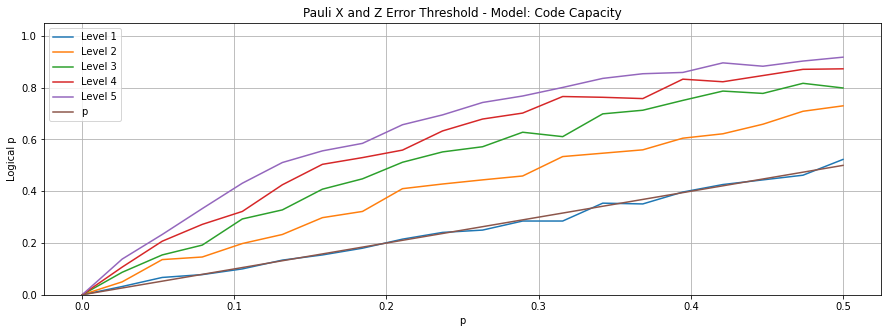

In [24]:
 """ Code Capacity Simulations """

# Create Plot For Results
fig = plt.figure(figsize = (15,5))
plt.title('Pauli X and Z Error Threshold - Model: Code Capacity')
plt.plot(probs, ccLevel1, label = 'Level 1')
plt.plot(probs, ccLevel2, label = 'Level 2')
plt.plot(probs, ccLevel3, label = 'Level 3')
plt.plot(probs, ccLevel4, label = 'Level 4')
plt.plot(probs, ccLevel5, label = 'Level 5')
plt.plot(probs, probs, label = 'p')
plt.xlabel('p')
plt.ylabel('Logical p')
plt.ylim([0,1.05])
plt.legend()
plt.grid()
plt.show()

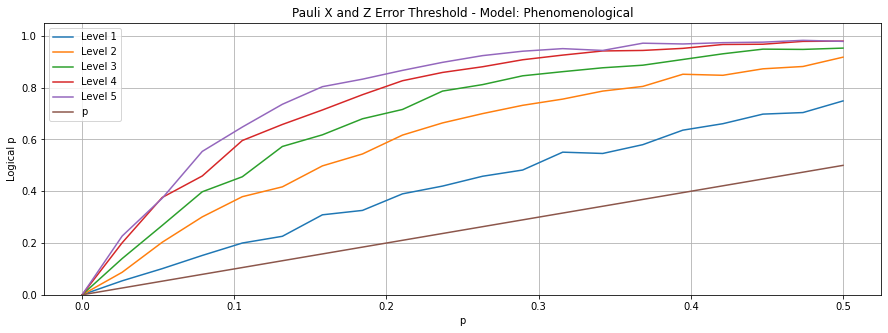

In [25]:
 """ Phenomenological Simulations """

# Create Plot For Results
fig = plt.figure(figsize = (15,5))
plt.title('Pauli X and Z Error Threshold - Model: Phenomenological')
plt.plot(probs, phLevel1, label = 'Level 1')
plt.plot(probs, phLevel2, label = 'Level 2')
plt.plot(probs, phLevel3, label = 'Level 3')
plt.plot(probs, phLevel4, label = 'Level 4')
plt.plot(probs, phLevel5, label = 'Level 5')
plt.plot(probs, probs, label = 'p')
plt.xlabel('p')
plt.ylabel('Logical p')
plt.ylim([0,1.05])
plt.legend()
plt.grid()